In [63]:
import random
import networkx as nx
from networkx.algorithms import bipartite
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
from matplotlib.transforms import IdentityTransform, TransformedBbox, Bbox

import sympy
import scipy
import numpy as np

# x, y, z = sympy.symbols('x y z')
sympy.init_printing(use_unicode=True)


class AngleAnnotation(Arc):
    """
    Draws an arc between two vectors which appears circular in display space.
    """
    def __init__(self, xy, p1, p2, size=75, unit="points", ax=None,
                 text="", textposition="inside", text_kw=None, **kwargs):
        """
        Parameters
        ----------
        xy, p1, p2 : tuple or array of two floats
            Center position and two points. Angle annotation is drawn between
            the two vectors connecting *p1* and *p2* with *xy*, respectively.
            Units are data coordinates.

        size : float
            Diameter of the angle annotation in units specified by *unit*.

        unit : str
            One of the following strings to specify the unit of *size*:

            * "pixels": pixels
            * "points": points, use points instead of pixels to not have a
              dependence on the DPI
            * "axes width", "axes height": relative units of Axes width, height
            * "axes min", "axes max": minimum or maximum of relative Axes
              width, height

        ax : `matplotlib.axes.Axes`
            The Axes to add the angle annotation to.

        text : str
            The text to mark the angle with.

        textposition : {"inside", "outside", "edge"}
            Whether to show the text in- or outside the arc. "edge" can be used
            for custom positions anchored at the arc's edge.

        text_kw : dict
            Dictionary of arguments passed to the Annotation.

        **kwargs
            Further parameters are passed to `matplotlib.patches.Arc`. Use this
            to specify, color, linewidth etc. of the arc.

        """
        self.ax = ax or plt.gca()
        self._xydata = xy  # in data coordinates
        self.vec1 = p1
        self.vec2 = p2
        self.size = size
        self.unit = unit
        self.textposition = textposition

        super().__init__(self._xydata, size, size, angle=0.0,
                         theta1=self.theta1, theta2=self.theta2, **kwargs)

        self.set_transform(IdentityTransform())
        self.ax.add_patch(self)

        self.kw = dict(ha="center", va="center",
                       xycoords=IdentityTransform(),
                       xytext=(0, 0), textcoords="offset points",
                       annotation_clip=True)
        self.kw.update(text_kw or {})
        self.text = ax.annotate(text, xy=self._center, **self.kw)

    def get_size(self):
        factor = 1.
        if self.unit == "points":
            factor = self.ax.figure.dpi / 72.
        elif self.unit[:4] == "axes":
            b = TransformedBbox(Bbox.unit(), self.ax.transAxes)
            dic = {"max": max(b.width, b.height),
                   "min": min(b.width, b.height),
                   "width": b.width, "height": b.height}
            factor = dic[self.unit[5:]]
        return self.size * factor

    def set_size(self, size):
        self.size = size

    def get_center_in_pixels(self):
        """return center in pixels"""
        return self.ax.transData.transform(self._xydata)

    def set_center(self, xy):
        """set center in data coordinates"""
        self._xydata = xy

    def get_theta(self, vec):
        vec_in_pixels = self.ax.transData.transform(vec) - self._center
        return np.rad2deg(np.arctan2(vec_in_pixels[1], vec_in_pixels[0]))

    def get_theta1(self):
        return self.get_theta(self.vec1)

    def get_theta2(self):
        return self.get_theta(self.vec2)

    def set_theta(self, angle):
        pass

    # Redefine attributes of the Arc to always give values in pixel space
    _center = property(get_center_in_pixels, set_center)
    theta1 = property(get_theta1, set_theta)
    theta2 = property(get_theta2, set_theta)
    width = property(get_size, set_size)
    height = property(get_size, set_size)

    # The following two methods are needed to update the text position.
    def draw(self, renderer):
        self.update_text()
        super().draw(renderer)

    def update_text(self):
        c = self._center
        s = self.get_size()
        angle_span = (self.theta2 - self.theta1) % 360
        angle = np.deg2rad(self.theta1 + angle_span / 2)
        r = s / 2
        if self.textposition == "inside":
            r = s / np.interp(angle_span, [60, 90, 135, 180],
                                          [3.3, 3.5, 3.8, 4])
        self.text.xy = c + r * np.array([np.cos(angle), np.sin(angle)])
        if self.textposition == "outside":
            def R90(a, r, w, h):
                if a < np.arctan(h/2/(r+w/2)):
                    return np.sqrt((r+w/2)**2 + (np.tan(a)*(r+w/2))**2)
                else:
                    c = np.sqrt((w/2)**2+(h/2)**2)
                    T = np.arcsin(c * np.cos(np.pi/2 - a + np.arcsin(h/2/c))/r)
                    xy = r * np.array([np.cos(a + T), np.sin(a + T)])
                    xy += np.array([w/2, h/2])
                    return np.sqrt(np.sum(xy**2))

            def R(a, r, w, h):
                aa = (a % (np.pi/4))*((a % (np.pi/2)) <= np.pi/4) + \
                     (np.pi/4 - (a % (np.pi/4)))*((a % (np.pi/2)) >= np.pi/4)
                return R90(aa, r, *[w, h][::int(np.sign(np.cos(2*a)))])

            bbox = self.text.get_window_extent()
            X = R(angle, r, bbox.width, bbox.height)
            trans = self.ax.figure.dpi_scale_trans.inverted()
            offs = trans.transform(((X-s/2), 0))[0] * 72
            self.text.set_position([offs*np.cos(angle), offs*np.sin(angle)])


def plot_angle(ax, pos, angle, length=0.95, acol="C0", **kwargs):
    vec2 = np.array([np.cos(np.deg2rad(angle)), np.sin(np.deg2rad(angle))])
    xy = np.c_[[length, 0], [0, 0], vec2*length].T + np.array(pos)
    ax.plot(*xy.T, color=acol)
    return AngleAnnotation(pos, xy[0], xy[2], ax=ax, **kwargs)

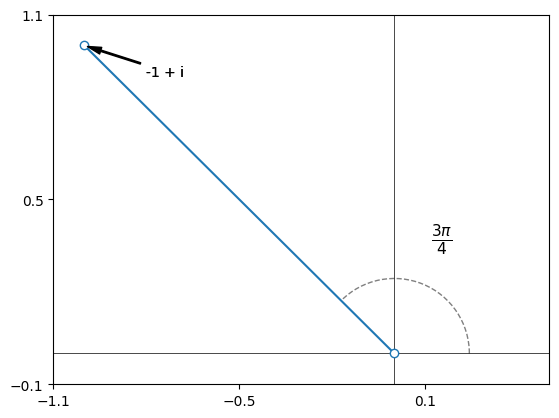

In [91]:
# 13.2: 9

x = np.linspace(-1, 0, 10)
y = -x

fig, ax = plt.subplots()
xlim = (-1.1, 0.5)
ylim = (-0.1, 1.1)
plt.axhline(0, color='black', linewidth=.5)
plt.axvline(0, color='black', linewidth=.5)
ax.set(xlim=xlim, xticks=np.arange(*xlim, step=0.6),
       ylim=ylim, yticks=np.arange(*ylim, step=0.6))

ax.annotate('-1 + i', xy=(-1, 1), xytext=(-0.8, 0.9),
            arrowprops=dict(facecolor='black', width=1, headwidth=5, headlength=10, shrink=0.05))

ax.annotate('-1 + i', xy=(-1, 1), xytext=(-0.8, 0.9))

ax.plot(x, y, 'o', 
         linestyle='-', 
         markevery=[0, -1], 
         markerfacecolor='white')

AngleAnnotation((0, 0), (1, 0), (-1, 1), ax=ax, size=150, text=r"$\frac{3\pi}{4}$",
                      linestyle="--", color="gray", textposition="outside",
                      text_kw=dict(fontsize=16, color="black"))

plt.show()

## 13.2, 9

$$\begin{aligned}
\tan \theta &= \frac{y}{x} \\
&= \frac{1}{-1} \\
&= -1 \\
\arg z &= \theta = \arctan (-1) \\
&= -\frac{\pi}{4} \pm 2n\pi \; (n=0, 1, \dots) \\
\text{Arg }z &= \frac{3\pi}{4} \\
\end{aligned}$$


# 13.3, 15

$$\begin{aligned}
f(z) &= |z|^2 \mathfrak{Im} (1/z) \\
f'(z) &= \lim_{\Delta z \rightarrow 0}\frac{f(z+\Delta z)-f(z)}{\Delta z} \\
&= \lim_{\Delta z \rightarrow 0}\frac{|(z+\Delta z)|^2\mathfrak{Im}(\frac{1}{z+\Delta z})-|z|^2 \mathfrak{Im} (1/z)}{\Delta z} \\
&= \lim_{\Delta z \rightarrow 0}\frac{|(z+\Delta z)|^2 \frac{1}{2i}(\frac{1}{z+\Delta z}-\overline{\frac{1}{z+\Delta z}})-|z|^2 \frac{1}{2i} (1/z-\overline{1/z})}{\Delta z} \\
&= \lim_{\Delta z \rightarrow 0}\frac{ |(z+\Delta z)|^2(\frac{1}{z+\Delta z}-\overline{\frac{1}{z+\Delta z}})- |z|^2(1/z-\overline{1/z}) }{2i\Delta z} \\
\end{aligned}$$

## 13.4, 21

Determine a and b so that the given function is harmonic and find a harmonic conjugate.

$u = e^{\pi x} \cos{av}$

$$\begin{aligned}
u_x &= \pi e^{\pi x}\cos{av} \\
u_{xx} &= 0 \\
u_y &= 0 \\
v_y &= u_x = \pi e^{\pi x}\cos{av} \\
a &= \pi \\
v_x &= -u_y = 0 \\
v & = \int \pi e^{\pi x}\cos{\pi v} \; dy = y\pi e^{\pi x}\cos{\pi v} + h(x) \\
v_x &= \frac{dh}{dx} y\pi e^{\pi x}\cos{\pi v}  \\
&= y\pi^2 e^{\pi x}\cos{\pi v} + h(x) = 0 \\
\frac{dh}{dx} &= -y\pi^2 e^{\pi x}\cos{\pi v}
\end{aligned}$$


## 13.5: 9

Write $4 + 3i$ in exponential form.

$$\begin{aligned}
z &= re^{i\theta} \\
r &= 5 \\
\theta &= \arctan{\frac{3}{4}} \approx 0.64 \\
z &= 5e^{0.64i} \\
\end{aligned}$$

## 13.7: 15

$\ln{7} \approx 1.94591 \pm 2n\pi i$

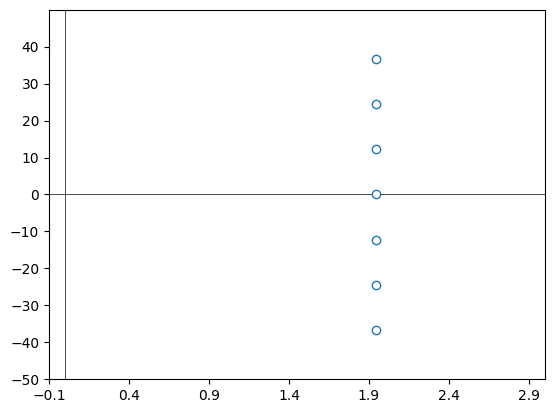

In [106]:
x = np.array([1.94591]*7)
y = np.array([1.94591 * n * np.pi * 2 for n in range(-3, 4)]) 

fig, ax = plt.subplots()
xlim = (-0.1, 3)
ylim = (-50, 50)

plt.axhline(0, color='black', linewidth=.5)
plt.axvline(0, color='black', linewidth=.5)
ax.set(xlim=xlim, xticks=np.arange(*xlim, step=0.5),
       ylim=ylim, yticks=np.arange(*ylim, step=10))

# ax.annotate('-1 + i', xy=(-1, 1), xytext=(-0.8, 0.9),
#             arrowprops=dict(facecolor='black', width=1, headwidth=5, headlength=10, shrink=0.05))

# ax.annotate('-1 + i', xy=(-1, 1), xytext=(-0.8, 0.9))

ax.plot(x, y, 'o', 
         # linestyle='-', 
         # markevery=[0, -1], 
         markerfacecolor='white')

plt.show()